In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
from collections import Counter
from tqdm import tqdm
#from ncls import NCLS
import matplotlib.pyplot as plt
import os
import re
import warnings
from collections import Counter
from glob import glob
# Suppress the DtypeWarning
warnings.filterwarnings("ignore", category=Warning)
import matplotlib.pyplot as plt

In [2]:
metafile = pd.read_csv('/datasets/Public_Datasets/Dracheva_PsychEncode_development/processed/PEC_donor_LIMS.csv', header=0, sep=',')
qcfile = pd.read_csv('/datasets/Public_Datasets/Dracheva_PsychEncode_development/processed/metadata_DNA_QC.tsv.gz',index_col = [0],compression='gzip', header=0, sep='\t')
glob_methy = pd.read_csv('/datasets/Public_Datasets/Dracheva_PsychEncode_development/processed/Individual_globalMethylation_autosome_cov3to50_all.tsv.gz',index_col = [0],compression='gzip', header=0, sep='\t')

### Read Methylation file

In [3]:
def sample_to_period(sample):
    period = metafile[metafile['Sample ID'] == sample]['period'].iloc[0]
    return period

In [4]:
def sample_to_gender(sample):
    sex = metafile[metafile['Sample ID'] == sample]['sex'].iloc[0]
    return sex

In [8]:
def read_dataframe(file_path):
    return pd.read_csv(file_path, delimiter='\t', compression='gzip', header=None,
                       names=['chr', 'start', 'end', 'geneID', 'gene', 'index', 'plot_index','mc', 'cov'])

def process_files(directory_path, metafile, celltype,ctype):
    if celltype == 'GABA':
        file_pattern = f'allc_*GABA*{ctype}*.gz'
        df_col = 'methyl_GABA'
    else:
        file_pattern = f'allc_*GLU*{ctype}*.gz'
        df_col = 'methyl_GLU'
        
    matching_files = sorted(glob(f'{directory_path}/{file_pattern}'))

    meta_gene = []

    for sampleID in tqdm(metafile[metafile[df_col] == 'Yes']['Sample ID']):
        files = [file for file in matching_files if any(pattern in file for pattern in [sampleID + '-', sampleID + '_'])]
        
        if qcfile.loc[f'{sampleID}_{celltype}_BS']['DNA_passQC'] != 'True' or qcfile.loc[f'{sampleID}_{celltype}_OXBS']['DNA_passQC'] != 'True':
            continue
        #print(files)
        if len(files) != 2:
            print(files)
            print(f'{sampleID} does not have both files')
            continue

        #tqdm.write(f'Reading {sampleID} files')
        oxbsfile, bsfile = (files[0], files[1]) if 'oxbs' in files[0].lower() else (files[1], files[0])

        df_OxBS = read_dataframe(oxbsfile)
        df_BS = read_dataframe(bsfile)

        df_OxBS, df_BS = df_OxBS[df_OxBS['cov'] > 10], df_BS[df_BS['cov'] > 10]

        df_merged = pd.merge(df_OxBS, df_BS[['gene', 'index','plot_index', 'mc', 'cov']], how='inner', on=['gene', 'index','plot_index'])

        df_merged['mcg'] = df_merged['mc_x'] / df_merged['cov_x']
        df_merged['hmcg'] = (df_merged['mc_y'] / df_merged['cov_y']) - df_merged['mcg']
        df_merged['tmcg'] = (df_merged['mc_y'] / df_merged['cov_y'])
        df_merged = df_merged[df_merged['hmcg'] > 0]
        df_merged['sample'] = sampleID
        df_merged['age_group'] = sample_to_period(sampleID)
        df_merged['sex'] = sample_to_gender(sampleID)

        meta_gene.append(df_merged)

    return pd.concat(meta_gene)


directory_path = '/datasets/Public_Datasets/Dracheva_PsychEncode_development/processed/regionMethylation/genebody_flanking_100kb/'
Celltype = 'GABA'
ctxt = 'CH'
result = process_files(directory_path, metafile, Celltype,ctxt)


100%|██████████| 82/82 [12:08<00:00,  8.89s/it]


In [9]:
result_mean  = result.groupby(['geneID','age_group','plot_index']).mean().reset_index()
result_mean.head()

,geneID,age_group,plot_index,start,end,mc_x,cov_x,mc_y,cov_y,mcg,hmcg,tmcg
0,ENSG00000000003.15,Adolescence,1,100688991.0,100689991.0,27.625000,997.500000,49.750000,1246.875000,0.029809,0.011330,0.041139
1,ENSG00000000003.15,Adolescence,2,100687991.0,100688991.0,62.090909,1096.000000,97.454545,1198.090909,0.068457,0.018463,0.086919
2,ENSG00000000003.15,Adolescence,3,100686991.0,100687991.0,49.636364,1061.545455,86.636364,1289.727273,0.056460,0.015452,0.071912
3,ENSG00000000003.15,Adolescence,4,100685991.0,100686991.0,29.428571,1074.571429,73.285714,1521.714286,0.029332,0.021081,0.050413
4,ENSG00000000003.15,Adolescence,5,100684991.0,100685991.0,8.875000,1024.875000,23.875000,1517.375000,0.008769,0.007358,0.016127


In [6]:
#result['index'] = result['index']%num_subregions
# result = result[(result['chr'] != 'chrY') &(result['chr'] != 'chrX')]
# result['plot_index'] = [int(i[-1]) if i[0] == 'upstream' else 100 + int(i[-1]) if i[0] == 'gene' else 125 + int(i[-1]) for i in result['index'].str.split('_')]
# result.reset_index(inplace = True,drop = True)
# result.head()

,chr,start,end,geneID,gene,index,mc_x,cov_x,plot_index,mc_y,cov_y,mcg,hmcg,tmcg,sample,age_group,sex
0,chr1,822138,823138,ENSG00000228794.10,LINC01128,upstream_bin_48,48,52,48,48,50,0.923077,0.036923,0.960000,390,Infancy,Female
1,chr1,822206,823206,ENSG00000225880.5,LINC00115,downstream_bin_4,79,52,129,79,50,1.519231,0.060769,1.580000,390,Infancy,Female
2,chr1,822226,823226,ENSG00000288531.1,AL669831.7,upstream_bin_13,13,52,13,13,50,0.250000,0.010000,0.260000,390,Infancy,Female
3,chr1,822837,823837,ENSG00000177757.2,FAM87B,downstream_bin_4,79,72,129,79,57,1.097222,0.288743,1.385965,390,Infancy,Female
4,chr1,823065,824065,ENSG00000237491.10,LINC01409,downstream_bin_14,89,58,139,89,43,1.534483,0.535285,2.069767,390,Infancy,Female


In [10]:
result_mean.to_csv(f'{Celltype}_m{ctxt}_gene_100k.csv.gz',compression='gzip', index=False)

In [5]:
Celltype = 'GABA'
C = 'CG'
result_mean = pd.read_csv(f'{Celltype}_m{C}_gene_100k.csv.gz')

In [6]:
age_group_colors = ['#f2ab55','#b0742c','#855114','#0000FF','#4169E1','#33CCFF']

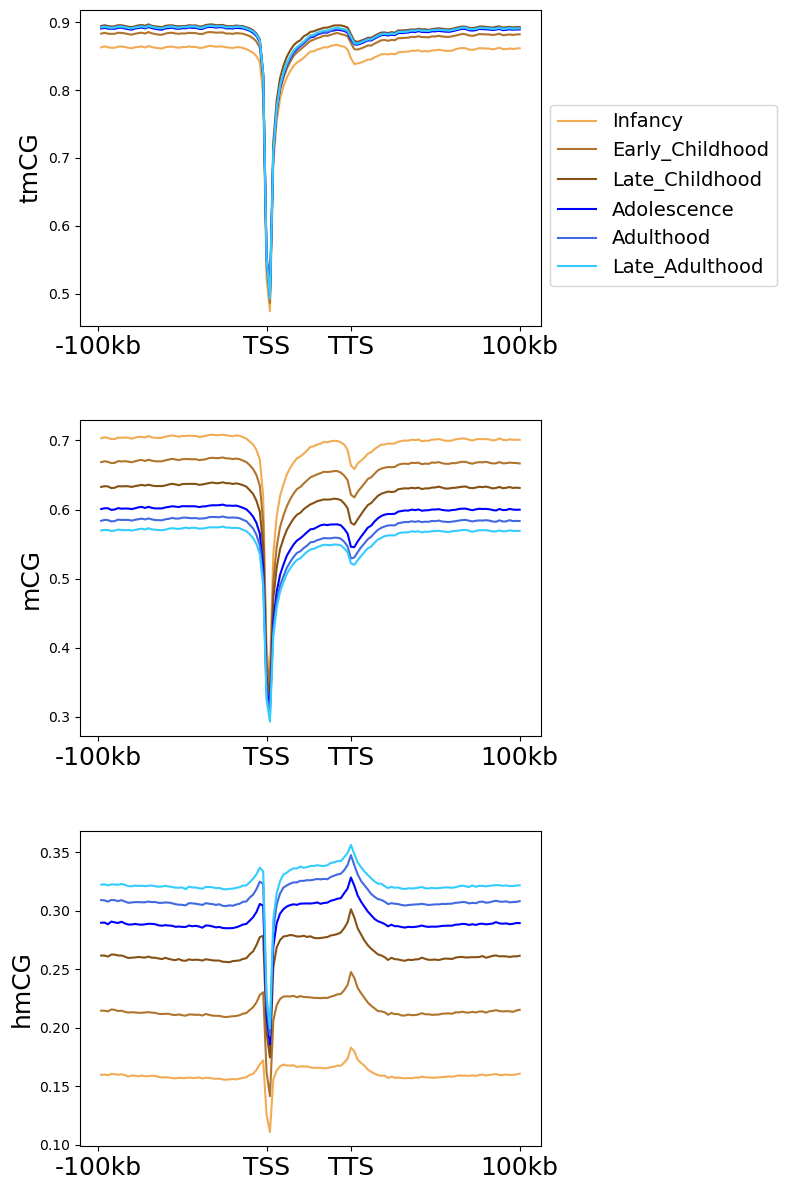

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(8,12))
legend_order = ['Infancy', 'Early_Childhood','Late_Childhood','Adolescence','Adulthood','Late_Adulthood']
metrics = ['tmcg', 'mcg', 'hmcg']
for i, metric in enumerate(metrics):
    ax = axes[i]

    for idx, age_group in enumerate(legend_order):
        grouped = result_mean[result_mean['age_group'] == age_group].groupby('plot_index')
        means = grouped[metric].mean()
       # std_dev = grouped[metric].std()
        
        ax.plot(means.index, means, label=age_group,color = age_group_colors[idx])
      #  ax.fill_between(means.index, means - std_dev, means + std_dev, alpha=0.3)

    ax.set_xticks([0, 50, 75, 125])
    ax.set_xticklabels(['-100kb', 'TSS', 'TTS', '100kb'],fontsize = 18)
    ax.set_ylabel(f'{metric}'.replace('cg', f'{C}'),fontsize = 18) #
    if i != 1:
        ax.legend().set_visible(False)
        ax.set_xlabel('')  # Hide xlabel for first two plots
    else:
        # Only show legend on third plot
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1.02, 2), borderaxespad=0.,prop={'size': 14})


plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
#plt.savefig(f'5kb_m{C}_genebody_{Celltype}.pdf')
plt.show()

In [65]:
monotonic_genes = pd.read_csv('../../rna_seq/monotonic_genes.csv',index_col = [0,1])
monotonic_genes.head()

trend
cell_type gene                     
GABA      ENSG00000001617.12      0
          ENSG00000002016.18      3
          ENSG00000003989.18      2
          ENSG00000004399.13      1
          ENSG00000004777.18      1

In [66]:
result_trend = result_mean.copy()

result_trend['trend'] = np.where(result_trend['geneID'].isin(monotonic_genes[monotonic_genes['trend'].isin([0,1])].loc[Celltype].index.values), 'Down',
                        np.where(result_trend['geneID'].isin(monotonic_genes[monotonic_genes['trend'].isin([2,3])].loc[Celltype].index.values), 'Up', 'Other'))


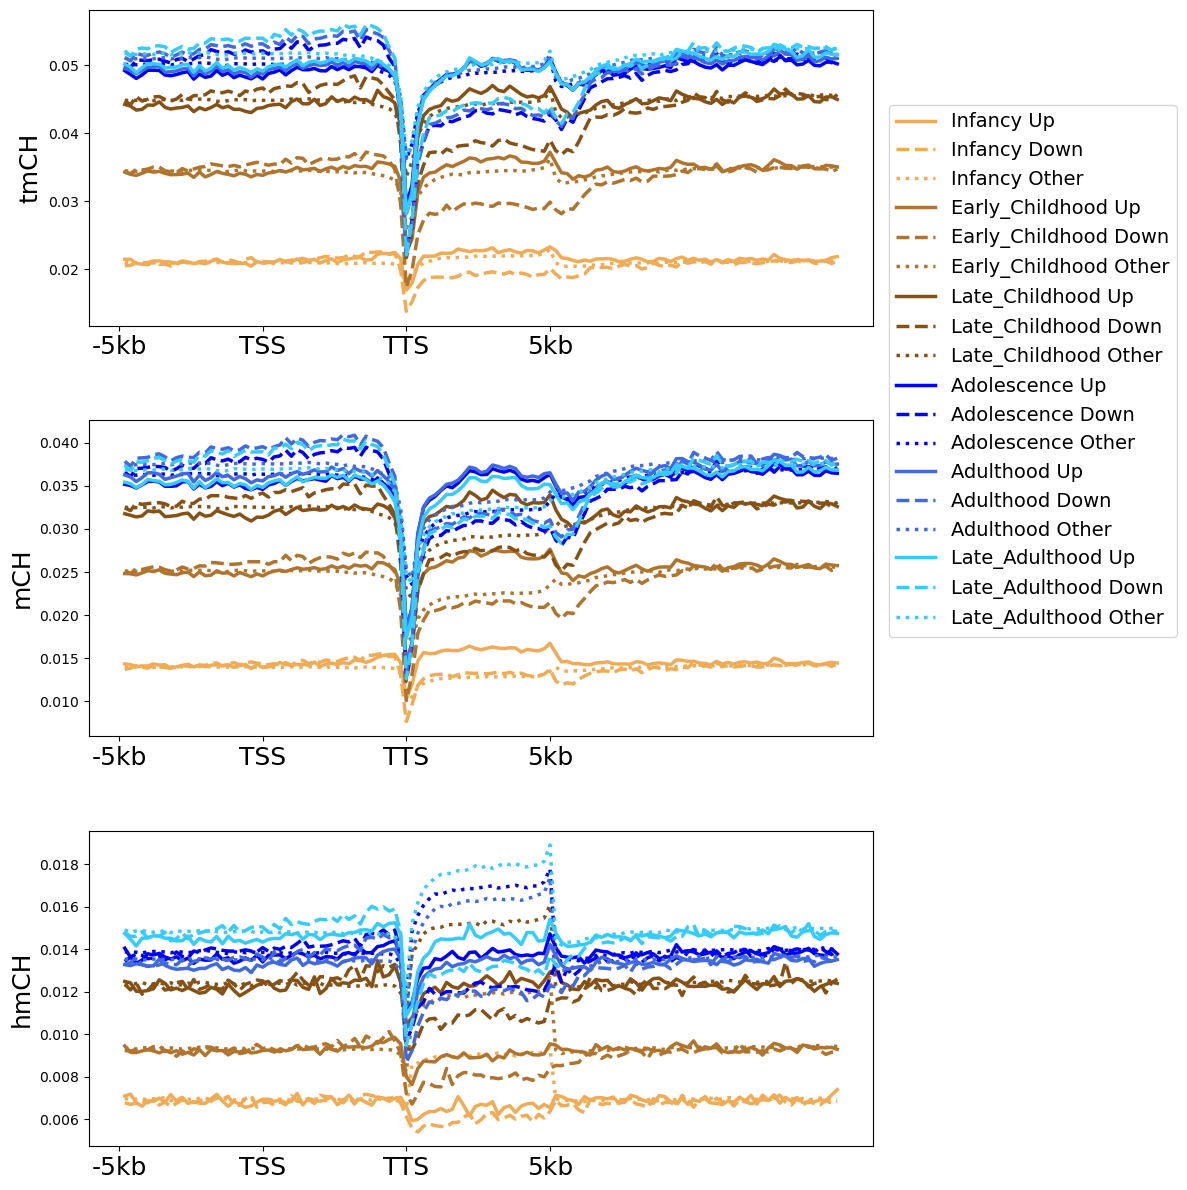

In [15]:
# import matplotlib.colors as mcolors
# fig, axes = plt.subplots(3, 1, figsize=(12,12))
# legend_order = ['Infancy', 'Early_Childhood','Late_Childhood','Adolescence','Adulthood','Late_Adulthood']
# trend_styles = {'Up': '-', 'Down': '--', 'Other': ':'}  # Solid line for 'up', Dashed line for 'down', Dotted line for 'NA'
# metrics = ['tmcg', 'mcg', 'hmcg']


# for i, metric in enumerate(metrics):
#     ax = axes[i]
#     for idx, age_group in enumerate(legend_order):
#         for trend, linestyle in trend_styles.items():

#             subset = result_trend[(result_trend['age_group'] == age_group) & (result_trend['trend'] == trend)]
#             if not subset.empty:
#                 grouped = subset.groupby('plot_index')
#                 means = grouped[metric].mean()
#                 ax.plot(means.index, means, label=f"{age_group} {trend}", 
#                         color=age_group_colors[idx], linestyle=linestyle,
#                         linewidth=2.5)

#     ax.set_xticks([0, 25, 50, 75])
#     ax.set_xticklabels(['-5kb', 'TSS', 'TTS', '5kb'],fontsize = 18)
#     ax.set_ylabel(f'{metric}'.replace('cg', f'{C}'),fontsize = 18)
#     if i != 1:
#         ax.legend().set_visible(False)
#         ax.set_xlabel('')  # Hide xlabel for first two plots
#     else:
#         # Only show legend on third plot
#         handles, labels = ax.get_legend_handles_labels()
#         ax.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1.02, 2), borderaxespad=0.,prop={'size': 14})

# plt.tight_layout()
# plt.subplots_adjust(hspace=0.3)
# #plt.savefig(f'RNA_trend_5kb_m{C}_flanking+genebody_{Celltype}.pdf')
# plt.show()

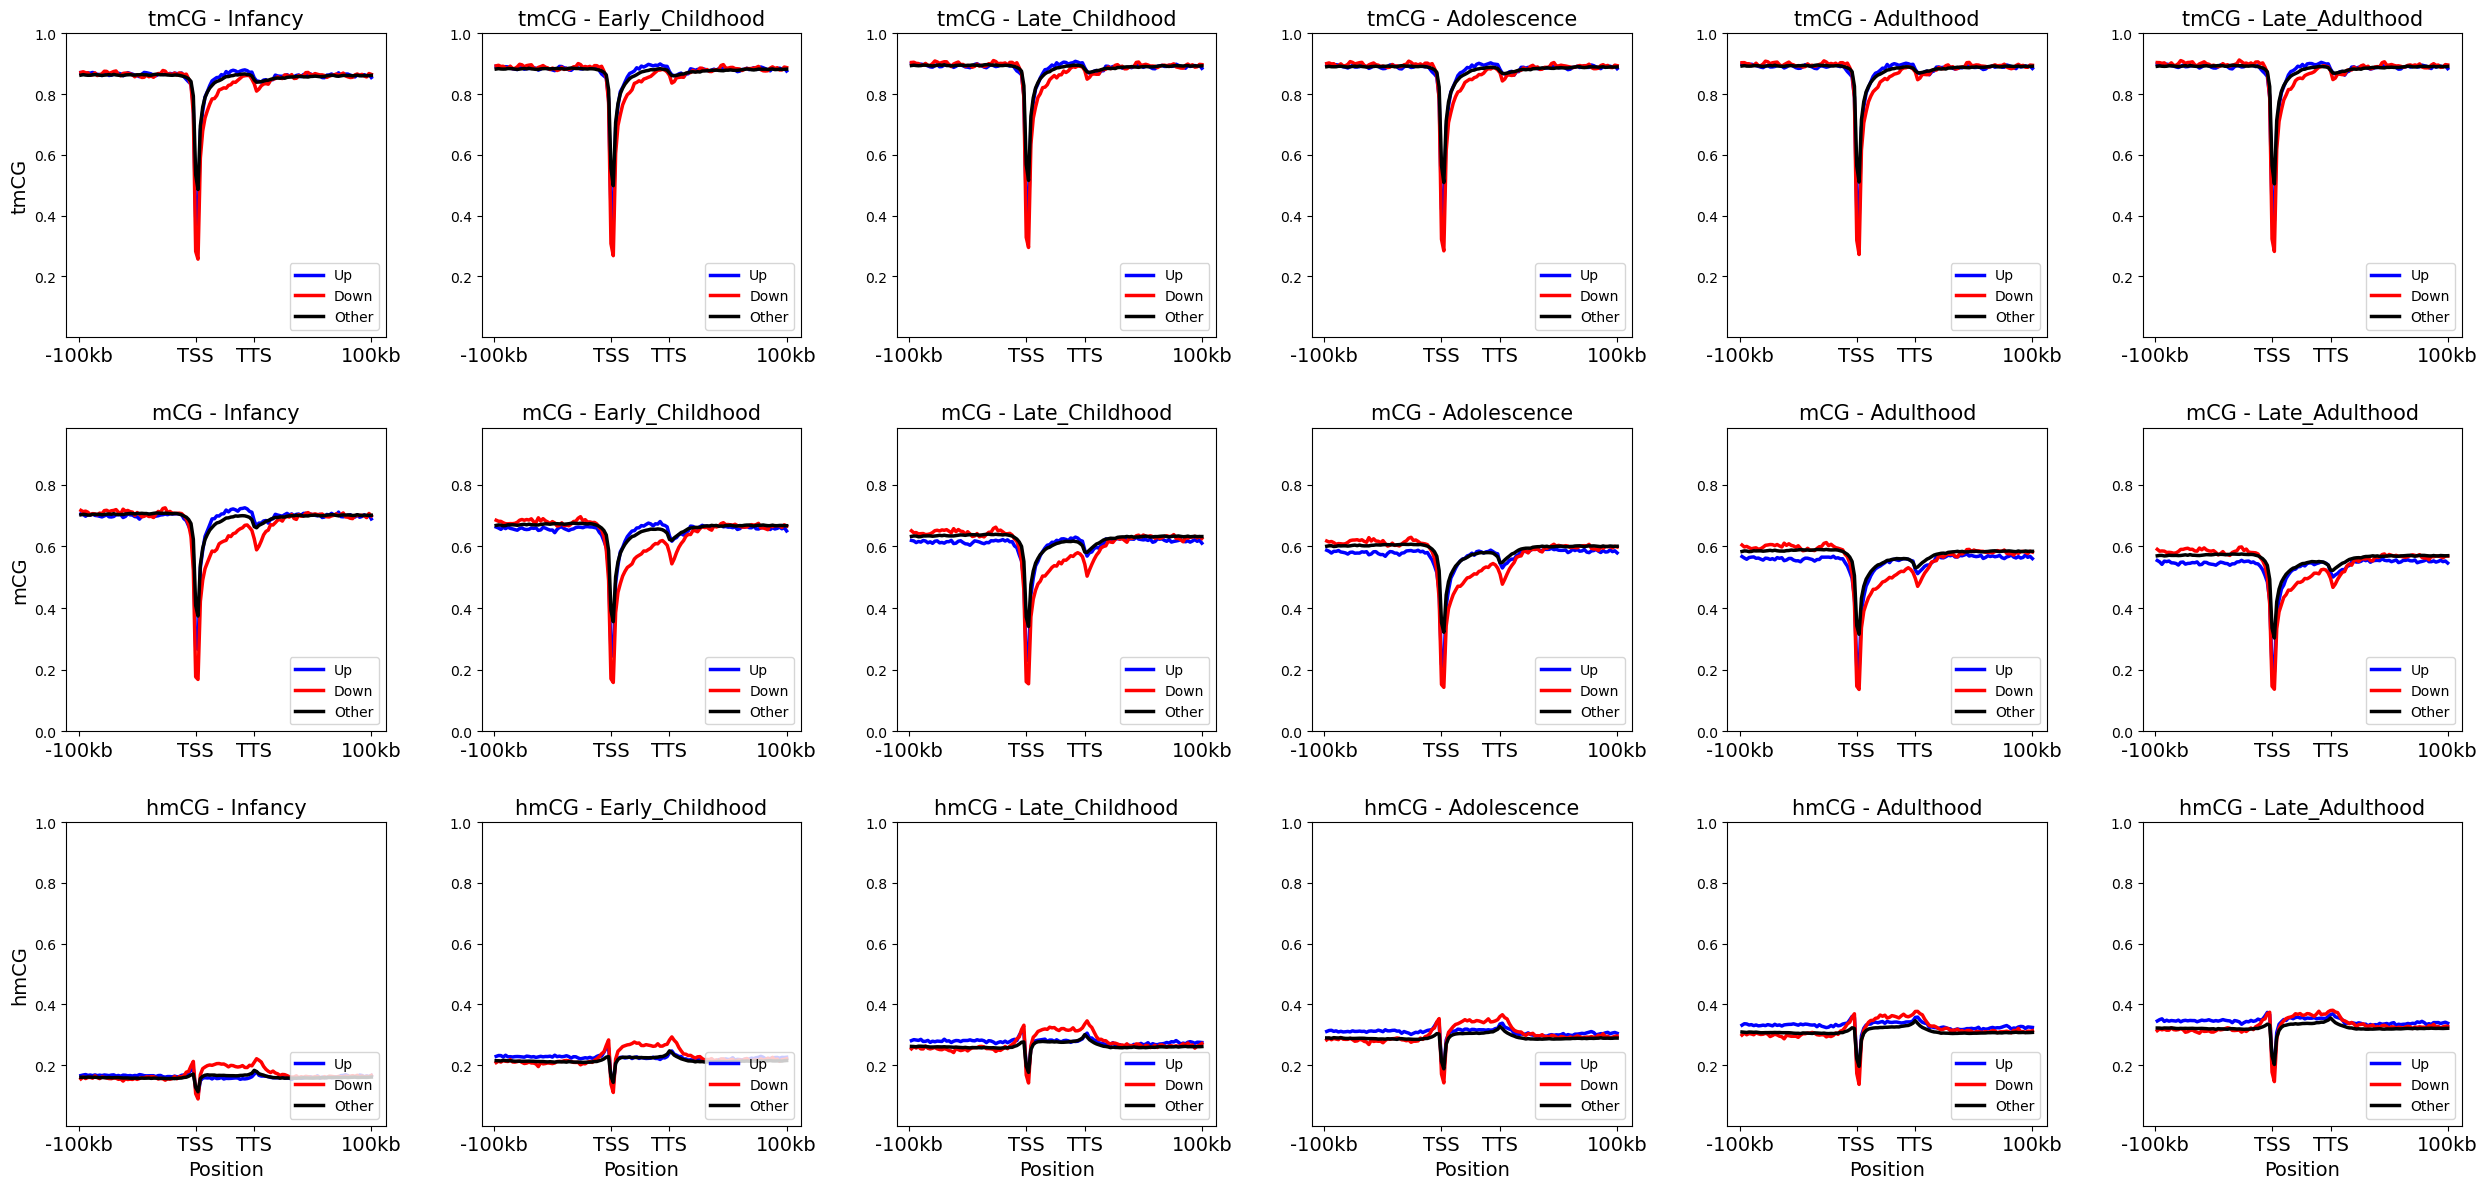

In [69]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Assuming the result_trend and other related data are defined


fig, axes = plt.subplots(3, 6, figsize=(25, 12))

legend_order = ['Infancy', 'Early_Childhood', 'Late_Childhood', 'Adolescence', 'Adulthood', 'Late_Adulthood']
trend_color = {'Up': 'blue', 'Down': 'red', 'Other': 'black'}

metrics = ['tmcg', 'mcg', 'hmcg']

# Calculate global min and max for each metric
y_lims = {}
for metric in metrics:
    metric_min = result_trend[metric].min()
    metric_max = result_trend[metric].max()
    y_lims[metric] = (metric_min, metric_max)
if C == 'CH':
     y_lims['tmcg'] = (0,0.065)
     y_lims['mcg'] = (0,0.05)
     y_lims['hmcg'] = (0,0.03)
     

for i, metric in enumerate(metrics):
    for j, age_group in enumerate(legend_order):
        ax = axes[i][j]
        for trend, color in trend_color.items():
            subset = result_trend[(result_trend['age_group'] == age_group) & (result_trend['trend'] == trend)]
            if not subset.empty:
                grouped = subset.groupby('plot_index')
                means = grouped[metric].mean()
                ax.plot(means.index, means, label=f"{trend}", 
                        color=color, linewidth=2.5)

        ax.set_xticks([0, 50, 75,125])
        ax.set_xticklabels(['-100kb', 'TSS', 'TTS', '100kb'], fontsize=14)
        ax.set_title(f"{metric} - {age_group}".replace('cg', f'{C}'), fontsize=15)
        ax.legend(loc="lower right", prop={'size': 10})

        # Set consistent y-axis limits for each metric

        ax.set_ylim(y_lims[metric])

        # Only label y-axis for the first column
        if j == 0:
            ax.set_ylabel(f'{metric}'.replace('cg', f'{C}'), fontsize=14)
        else:
            ax.set_ylabel('')
            
        # Only label x-axis for the bottom row
        if i == 2:
            ax.set_xlabel('Position', fontsize=14)
        else:
            ax.set_xlabel('')

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig(f'V2_RNA_trend_5kb_m{C}_flanking+genebody_{Celltype}_100kb.pdf')
plt.show()


In [8]:
all_DE = pd.read_csv('../../rna_seq/Dream_all_results.csv',index_col = [0])

In [14]:
age_group = 'Early_Childhood'
j = 0
g1 = legend_order[j].lower().replace('_','')
g2 = age_group.lower().replace('_','')
comp = f'{g1}-{g2}'
all_DE_subset = all_DE[(all_DE['comp'] == comp) & (all_DE['celltype'] == Celltype) & (all_DE['adj.P.Val'] < 0.05)]
result_trend = result_mean.copy()

result_trend['trend'] = np.where(result_trend['geneID'].isin(all_DE_subset[all_DE_subset['logFC'] >  0].index.values), 'Down',
                        np.where(result_trend['geneID'].isin(all_DE_subset[all_DE_subset['logFC'] < 0].index.values), 'Up', 'Non-DE'))


In [20]:
trend = 'Up'
metric = 'hmcg'
base = result_trend[(result_trend['age_group'] == legend_order[j]) & (result_trend['trend'] == trend)][['geneID',metric,'plot_index']]
current = result_trend[(result_trend['age_group'] == age_group) & (result_trend['trend'] == trend)][['geneID',metric,'plot_index']]


In [31]:
diff = pd.merge(base, current,  how='inner', left_on=['geneID','plot_index'], right_on = ['geneID','plot_index'])
diff['change'] = diff['hmcg_y'] - diff['hmcg_x']
diff_mean = diff.groupby(['plot_index']).mean()
diff_mean.head()

,hmcg_x,hmcg_y,change
plot_index,,,
1,0.160195,0.224529,0.064334
2,0.161866,0.226795,0.064929
3,0.167346,0.226529,0.059183
4,0.165584,0.227246,0.061661
5,0.164775,0.234762,0.069987


In [36]:
ax = axes[i][j]
g1 = legend_order[j].lower().replace('_','')
g2 = age_group.lower().replace('_','')
comp = f'{g1}-{g2}'
all_DE_subset = all_DE[(all_DE['comp'] == comp) & (all_DE['celltype'] == Celltype) & (all_DE['adj.P.Val'] < 0.05)]
result_trend = result_mean.copy()

result_trend['trend'] = np.where(result_trend['geneID'].isin(all_DE_subset[all_DE_subset['logFC'] >  0].index.values), 'Down',
                    np.where(result_trend['geneID'].isin(all_DE_subset[all_DE_subset['logFC'] < 0].index.values), 'Up', 'Non-DE'))



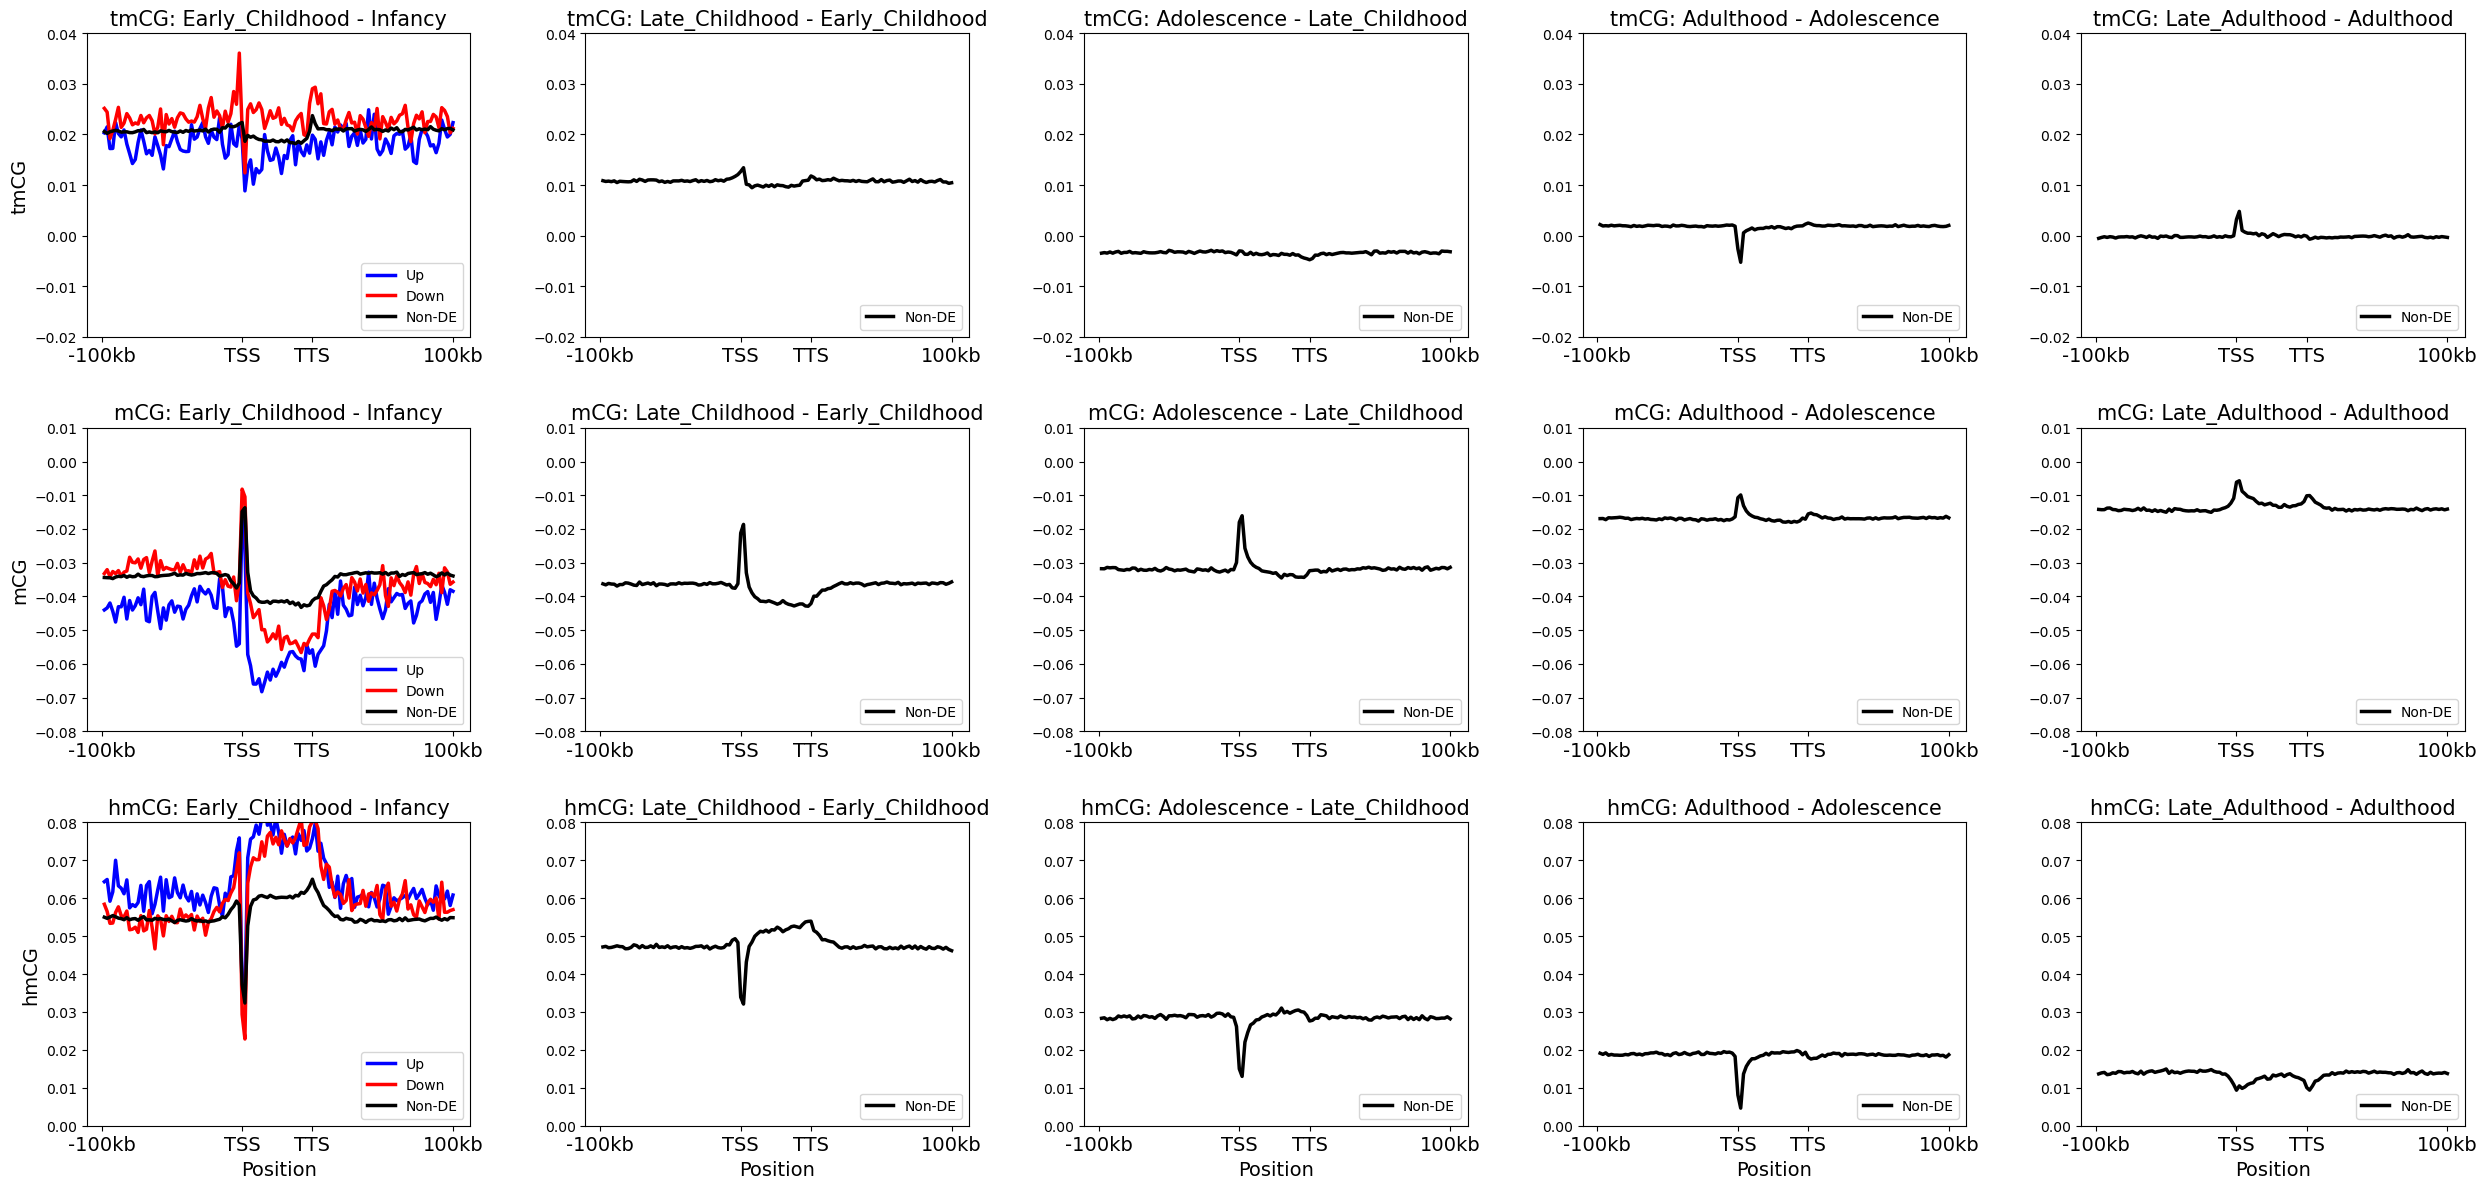

In [39]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Assuming the result_trend and other related data are defined


fig, axes = plt.subplots(3, 5, figsize=(25, 12))

legend_order = ['Infancy', 'Early_Childhood', 'Late_Childhood', 'Adolescence', 'Adulthood', 'Late_Adulthood']
trend_color = {'Up': 'blue', 'Down': 'red', 'Non-DE': 'black'}

metrics = ['tmcg', 'mcg', 'hmcg']

# Calculate global min and max for each metric
y_lims = {}
for metric in metrics:
    metric_min = result_trend[metric].min()
    metric_max = result_trend[metric].max()
    y_lims[metric] = (metric_min, metric_max)
if C == 'CG':
     y_lims['tmcg'] = (-0.02,0.04)
     y_lims['mcg'] = (-0.08,0.01)
     y_lims['hmcg'] = (0,0.08)
     

for i, metric in enumerate(metrics):
    for j, age_group in enumerate(legend_order[1:]):
        ax = axes[i][j]
        g1 = legend_order[j].lower().replace('_','')
        g2 = age_group.lower().replace('_','')
        comp = f'{g1}-{g2}'
        all_DE_subset = all_DE[(all_DE['comp'] == comp) & (all_DE['celltype'] == Celltype) & (all_DE['adj.P.Val'] < 0.05)]
        result_trend = result_mean.copy()

        result_trend['trend'] = np.where(result_trend['geneID'].isin(all_DE_subset[all_DE_subset['logFC'] >  0].index.values), 'Down',
                            np.where(result_trend['geneID'].isin(all_DE_subset[all_DE_subset['logFC'] < 0].index.values), 'Up', 'Non-DE'))

        for trend, color in trend_color.items():
            #print(legend_order[j],age_group)
            base = result_trend[(result_trend['age_group'] == legend_order[j]) & (result_trend['trend'] == trend)][['geneID',metric,'plot_index']]
            current = result_trend[(result_trend['age_group'] == age_group) & (result_trend['trend'] == trend)][['geneID',metric,'plot_index']]


            diff = pd.merge(base, current,  how='inner', left_on=['geneID','plot_index'], right_on = ['geneID','plot_index'])
            diff['change'] = diff[f'{metric}_y'] - diff[f'{metric}_x']
            diff_mean = diff.groupby(['plot_index']).mean()
            diff_mean.head()
            if not diff_mean.empty:
                # grouped = subset[['t','mcg','hmcg','plot_index','age_group']].groupby(['plot_index']).mean()
                # means = grouped[metric].mean()
                ax.plot(diff_mean.index, diff_mean['change'], label=f"{trend}", 
                        color=color, linewidth=2.5)

        ax.set_xticks([0, 50, 75,125])
        ax.set_xticklabels(['-100kb', 'TSS', 'TTS', '100kb'], fontsize=14)
        ax.set_title(f"{metric}: {age_group} - {legend_order[j]}".replace('cg', f'{C}'), fontsize=15)
        ax.legend(loc="lower right", prop={'size': 10})

        # Set consistent y-axis limits for each metric

        ax.set_ylim(y_lims[metric])

        # Only label y-axis for the first column
        if j == 0:
            ax.set_ylabel(f'{metric}'.replace('cg', f'{C}'), fontsize=14)
        else:
            ax.set_ylabel('')
            
        # Only label x-axis for the bottom row
        if i == 2:
            ax.set_xlabel('Position', fontsize=14)
        else:
            ax.set_xlabel('')

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)
#plt.savefig(f'V2_RNA_trend_5kb_m{C}_flanking+genebody_{Celltype}_100kb.pdf')
plt.show()


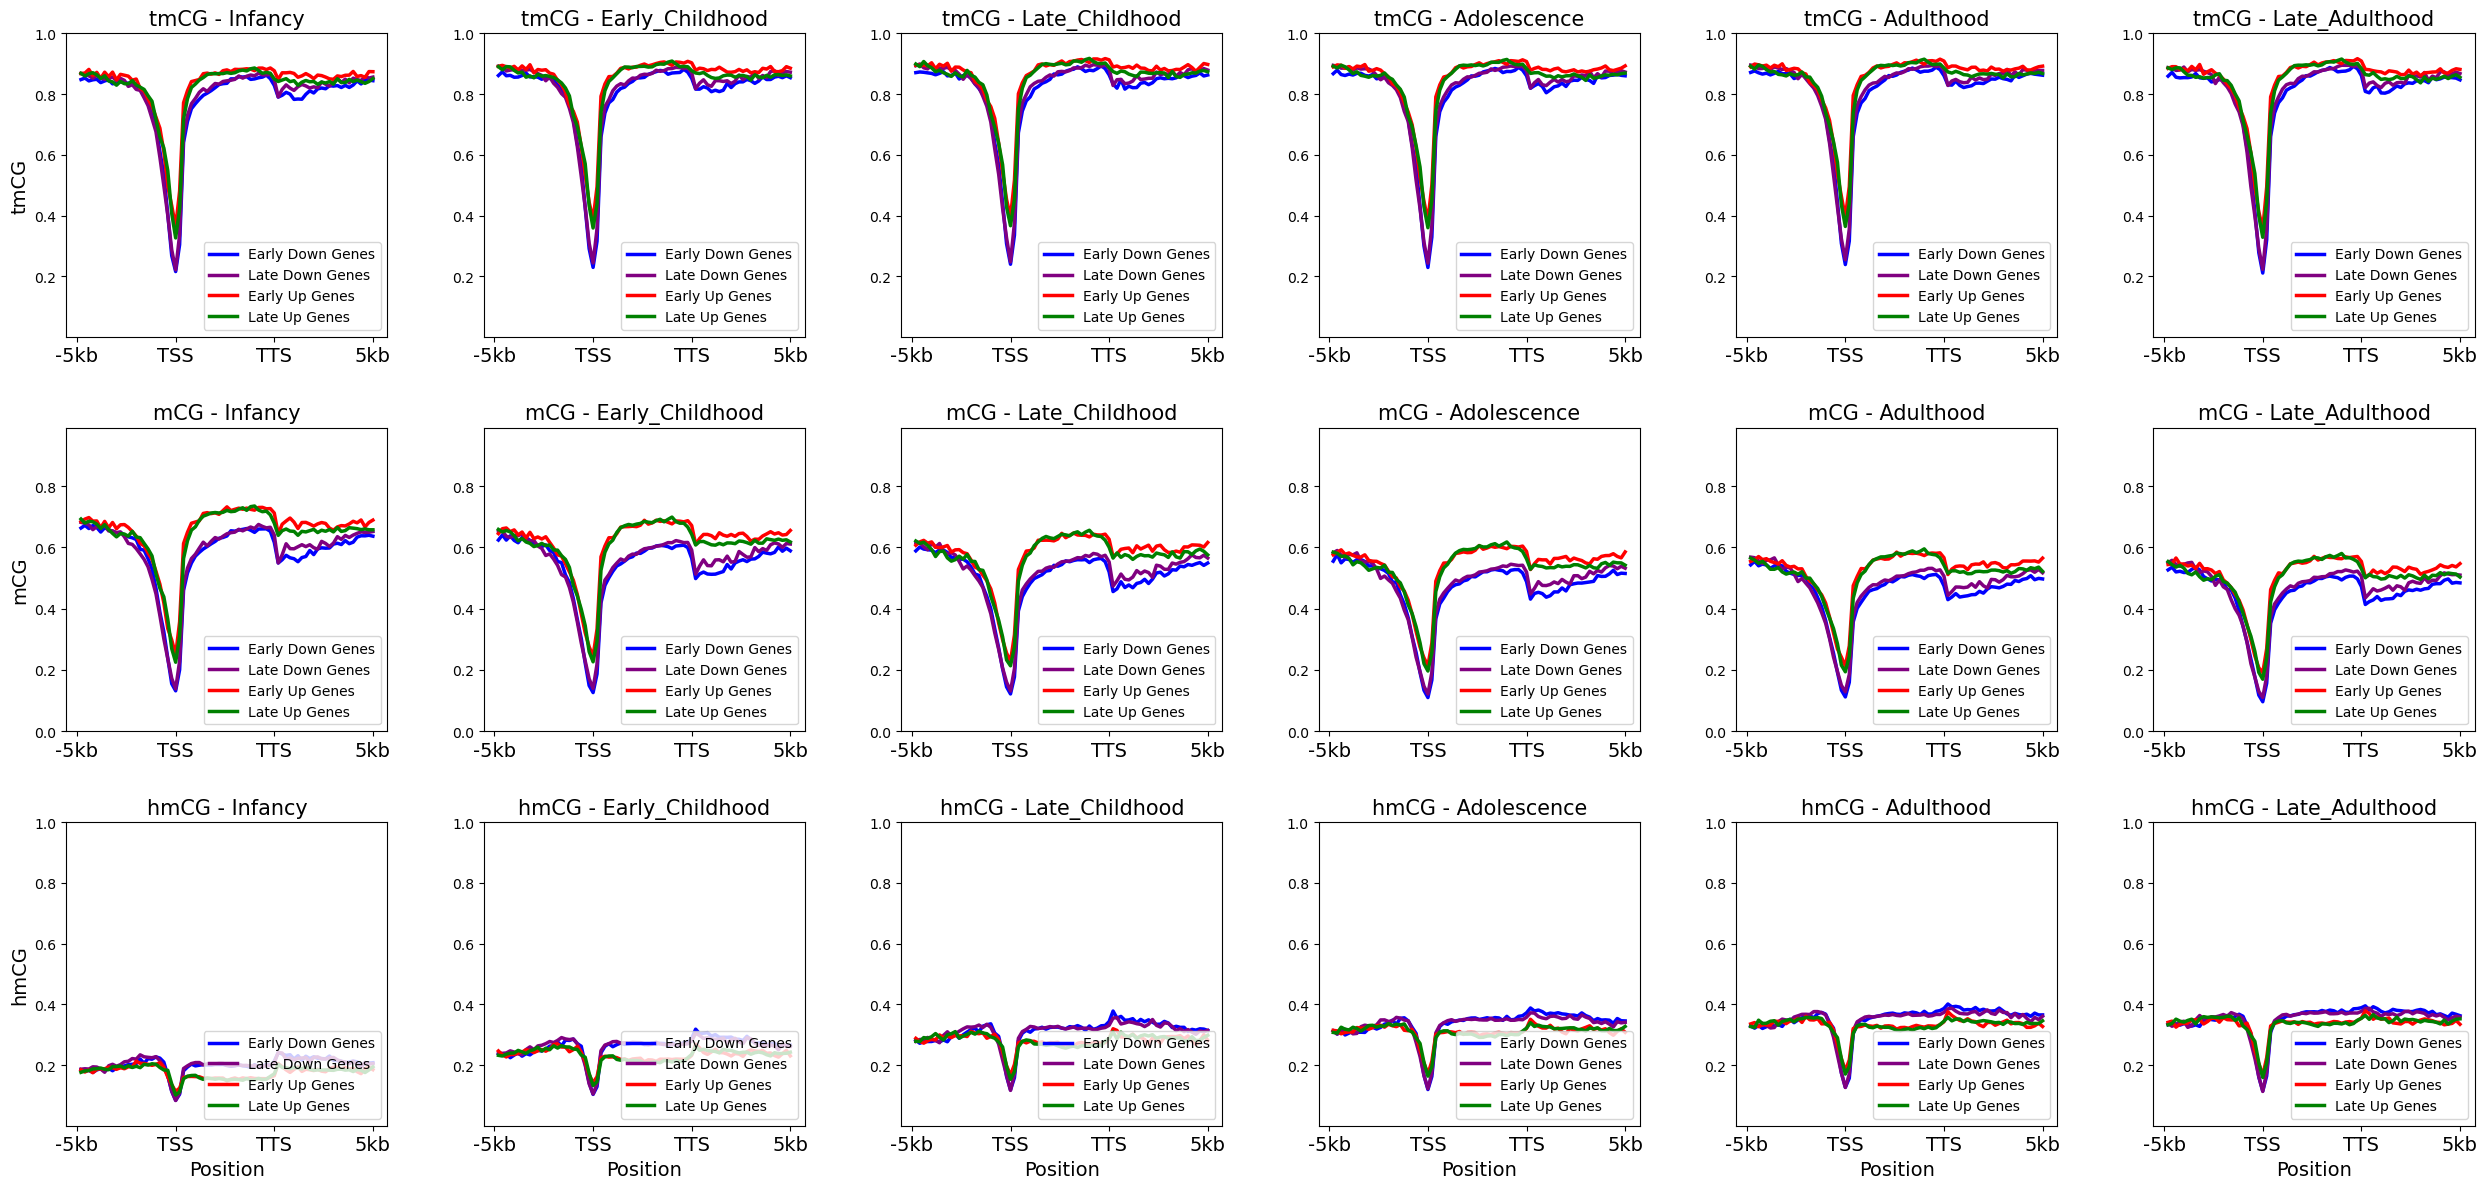

In [30]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Assuming the result_trend and other related data are defined


fig, axes = plt.subplots(3, 6, figsize=(25, 12))

legend_order = ['Infancy', 'Early_Childhood', 'Late_Childhood', 'Adolescence', 'Adulthood', 'Late_Adulthood']
trend_color = {'Early Down Genes':'blue', 'Late Down Genes':'purple',
               'Early Up Genes':'red','Late Up Genes':'green'}

metrics = ['tmcg', 'mcg', 'hmcg']

# Calculate global min and max for each metric
y_lims = {}
for metric in metrics:
    metric_min = result_trend[metric].min()
    metric_max = result_trend[metric].max()
    y_lims[metric] = (metric_min, metric_max)
if C == 'CH':
     y_lims['tmcg'] = (0,0.075)
     y_lims['mcg'] = (0,0.055)
     y_lims['hmcg'] = (0,0.03)
     

for i, metric in enumerate(metrics):
    for j, age_group in enumerate(legend_order):
        ax = axes[i][j]
        for trend, color in trend_color.items():
            subset = result_trend[(result_trend['age_group'] == age_group) & (result_trend['trend'] == trend)]
            if not subset.empty:
                grouped = subset.groupby('plot_index')
                means = grouped[metric].mean()
                ax.plot(means.index, means, label=f"{trend}", 
                        color=color, linewidth=2.5)

        ax.set_xticks([0, 25, 50, 75])
        ax.set_xticklabels(['-5kb', 'TSS', 'TTS', '5kb'], fontsize=14)
        ax.set_title(f"{metric} - {age_group}".replace('cg', f'{C}'), fontsize=15)
        ax.legend(loc="lower right", prop={'size': 10})

        # Set consistent y-axis limits for each metric

        ax.set_ylim(y_lims[metric])

        # Only label y-axis for the first column
        if j == 0:
            ax.set_ylabel(f'{metric}'.replace('cg', f'{C}'), fontsize=14)
        else:
            ax.set_ylabel('')
            
        # Only label x-axis for the bottom row
        if i == 2:
            ax.set_xlabel('Position', fontsize=14)
        else:
            ax.set_xlabel('')

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig(f'V3_RNA_trend_5kb_m{C}_flanking+genebody_{Celltype}.pdf')
plt.show()
